In [1]:
from scipy.stats import norm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from ipywidgets import interact, FloatSlider


In [2]:
class blackScholes:
    # Computing european call and put prices using the closed form solution 
    # of the Black-Scholes equation.
    
    def __init__(self, S, K, T, r, sigma):
        '''
        S: Price of underlying asset
        K: Strike price of option
        T: Time till expiration
        r: Risk-free interest rate
        sigma: Volatility of risky asset
        '''
        self.S = S
        self.K = K
        self.T = T
        self.r = r
        self.sigma = sigma
    
    def d1(self):
        return (np.log(self.S/self.K)+(self.r+0.5*(self.sigma**2))*self.T)/(self.sigma*(self.T**0.5))

    def d2(self):
        return (np.log(self.S/self.K)+(self.r-0.5*(self.sigma**2))*self.T)/(self.sigma*(self.T**0.5))
    
    def callPrice(self):
        return self.S*norm.cdf(self.d1(), 0, 1)-self.K*np.exp(-self.r*self.T)*norm.cdf(self.d2(), 0, 1)
    
    def putPrice(self):
        return self.K*np.exp(-self.r*self.T)*norm.cdf(-self.d2(), 0, 1)-self.S*norm.cdf(-self.d1(), 0, 1)


In [3]:
def optionPrice(S, K, T, r, sigma):
    eurOption = blackScholes(S, K, T, r, sigma)
    print('Call price is ' + str(np.round(eurOption.callPrice(), 2)) + ' and Put price is ' + str(np.round(eurOption.putPrice(), 2)))
    return eurOption.callPrice(), eurOption.putPrice()


In [4]:
optionPrice(100, 100, 1, 0.05, 0.2)


Call price is 10.45 and Put price is 5.57


(10.450583572185565, 5.573526022256971)

In [5]:
def optionPriceHeatmap(minSpot, maxSpot, K, T, r, minVol, maxVol):
    '''
    K: Strike price of option
    T: Time till expiration
    r: Risk-free interest rate
    minVol: Generate European option prices with volatility at least minVol
    maxVol: Generate European option prices with volatility at most maxVol
    minSpot: Generate European option prices with spot price at least minSpot
    maxSpot: Generate European option prices with spot price at most maxSpot
    '''
    # Given a fixed strike price, time till expiration and risk-free interest rate, we would
    # like to calculate the call or put price of an option for varying spot prices and varying
    # volatilities. We present this in the form of a heatmap.
    
    spotPrices = np.linspace(minSpot, maxSpot, 10)
    vols = np.linspace(minVol, maxVol, 10)
    callGrid = np.empty([len(vols), len(spotPrices)])
    putGrid = np.empty([len(vols), len(spotPrices)])
    for i, sigma in enumerate(vols):
        for j, S in enumerate(spotPrices):
            callGrid[i][j] = blackScholes(S, K, T, r, sigma).callPrice()
            putGrid[i][j] = blackScholes(S, K, T, r, sigma).putPrice()
    
    csfont = {'fontname':'Helvetica'}
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    sns.heatmap(callGrid, ax=ax[0], cmap='viridis', annot=True, fmt=".2f")
    ax[0].set_title('Call Option Prices for Strike = ' + str(K), fontsize=16, **csfont)
    ax[0].set_xlabel('Spot Price', fontsize=14, **csfont)
    ax[0].set_ylabel('Volatility', fontsize=14, **csfont)
    ax[0].set_xticklabels(np.round(spotPrices, 2))
    ax[0].set_yticklabels(np.round(vols, 2))
    sns.heatmap(putGrid, ax=ax[1], cmap='viridis', annot=True, fmt=".2f")
    ax[1].set_title('Put Option Prices for Strike = ' + str(K), fontsize=16, **csfont)
    ax[1].set_xlabel('Spot Price', fontsize=14, **csfont)
    ax[1].set_ylabel('Volatility', fontsize=14, **csfont)
    ax[1].set_xticklabels(np.round(spotPrices, 2))
    ax[1].set_yticklabels(np.round(vols, 2))
    plt.tight_layout()
    plt.savefig('Black_scholes_european_heatmap.png', dpi=800)
    plt.show()


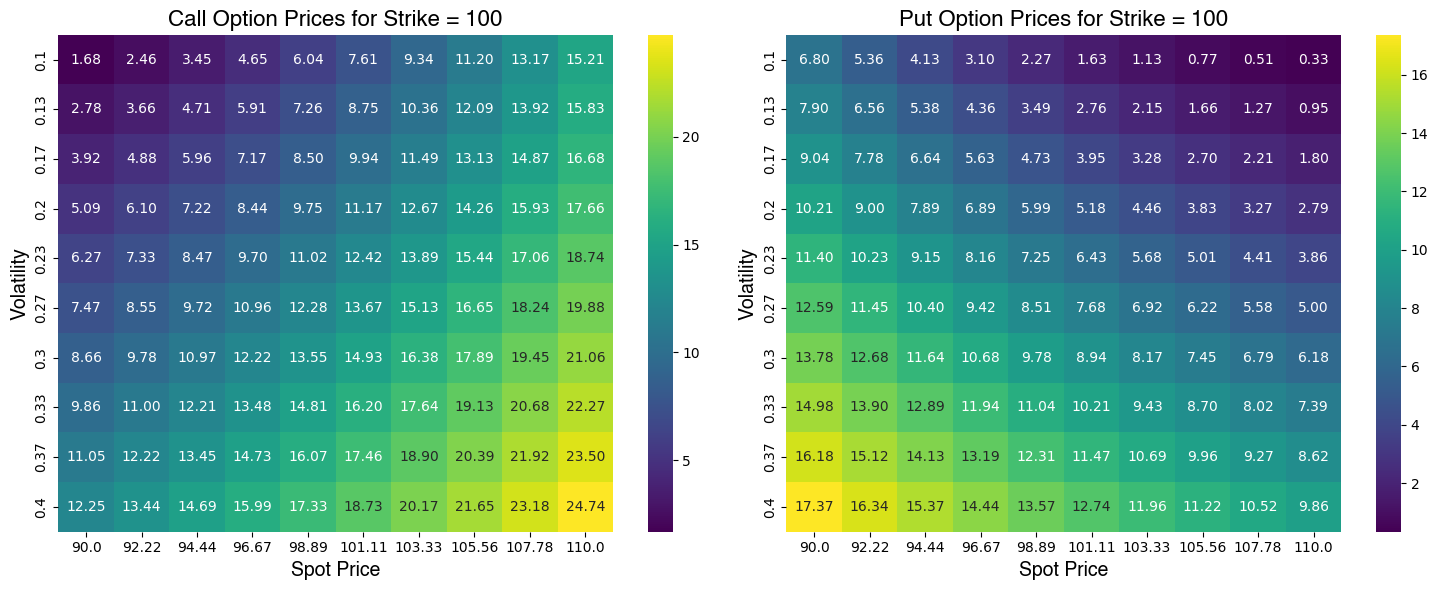

In [6]:
optionPriceHeatmap(90, 110, 100, 1, 0.05, 0.1, 0.4)


In [7]:
def optionProfitabilityHeatmap(minSpot, maxSpot, K, T, r, minVol, maxVol):
    '''
    K: Strike price of option
    T: Time till expiration
    r: Risk-free interest rate
    minVol: Generate European option prices with volatility at least minVol
    maxVol: Generate European option prices with volatility at most maxVol
    minSpot: Generate European option prices with spot price at least minSpot
    maxSpot: Generate European option prices with spot price at most maxSpot
    '''
    # Given a fixed strike price, time till expiration and risk-free interest rate, we would
    # like to calculate the profitability of a call or put option given the price of the
    # underlying at expiration. This is presented as a heat map with a slider to adjust the
    # price of the underlying at expiration.
    
    def genData(spotRange, K, T, r, volRange, F):
        spotPrices = np.linspace(minSpot, maxSpot, 10)
        vols = np.linspace(minVol, maxVol, 10)
        callProfGrid = np.empty([len(vols), len(spotPrices)])
        putProfGrid = np.empty([len(vols), len(spotPrices)])
        for i, sigma in enumerate(vols):
            for j, S in enumerate(spotPrices):
                callProfGrid[i][j] = -blackScholes(S, K, T, r, sigma).callPrice()+max(F-K, 0)
                putProfGrid[i][j] = -blackScholes(S, K, T, r, sigma).putPrice()+max(-F+K, 0)
        return spotPrices, vols, callProfGrid, putProfGrid
    
    def genHeatmap(F=K):
        csfont = {'fontname':'Helvetica'}
        fig, ax = plt.subplots(1, 2, figsize=(15, 6))
        spotPrices, vols, callProfGrid, putProfGrid = genData((minSpot, maxSpot), K, T, r, (minVol, maxVol), F)
        sns.heatmap(callProfGrid, ax=ax[0], cmap='RdYlGn', annot=True, fmt='.2f', vmin=-30, vmax=30)
        ax[0].set_title('Call Option Profitability for Strike = ' + str(K), fontsize=16, **csfont)
        ax[0].set_xlabel('Spot Price', fontsize=14, **csfont)
        ax[0].set_ylabel('Volatility', fontsize=14, **csfont)
        ax[0].set_xticklabels(np.round(spotPrices, 2))
        ax[0].set_yticklabels(np.round(vols, 2))
        sns.heatmap(putProfGrid, ax=ax[1], cmap='RdYlGn', annot=True, fmt='.2f', vmin=-30, vmax=30)
        ax[1].set_title('Put Option Profitability for Strike = ' + str(K), fontsize=16, **csfont)
        ax[1].set_xlabel('Spot Price', fontsize=14, **csfont)
        ax[1].set_ylabel('Volatility', fontsize=14, **csfont)
        ax[1].set_xticklabels(np.round(spotPrices, 2))
        ax[1].set_yticklabels(np.round(vols, 2))
        plt.tight_layout()
        plt.savefig('Black_scholes_european_profitability_heatmap.png', dpi=800)
        plt.show()
        
    interact(genHeatmap, F=FloatSlider(value=K, min=K*0.7, max=K*1.3, step=0.01, description='Expiration Price'))


In [8]:
optionProfitabilityHeatmap(90, 110, 100, 1, 0.05, 0.1, 0.4)


interactive(children=(FloatSlider(value=100.0, description='Expiration Price', max=130.0, min=70.0, step=0.01)…

In [9]:
def blackScholesMC(S, K, T, r, sigma, N, M):
    '''
    S: Price of underlying asset
    K: Strike price of option
    T: Time till expiration
    r: Risk-free interest rate
    sigma: Volatility of risky asset
    N: Number of time steps
    M: Number of simulations
    '''
    # Computing european call and put prices using the Monte Carlo method
    
    dt = T/N
    epsilon = np.random.normal(size=(N, M))
    delta = (r-0.5*sigma**2)*dt+sigma*np.sqrt(dt)*epsilon
    z0 = np.log(S)
    zT = z0+np.cumsum(delta, axis=0)
    zT = np.concatenate((np.full(shape=(1, M), fill_value=z0), zT))
    cT, pT = np.maximum(np.exp(zT)-K, 0), np.maximum(K-np.exp(zT), 0)
    callPrice, putPrice = np.exp(-r*T)*np.sum(cT[-1])/M, np.exp(-r*T)*np.sum(pT[-1])/M
    callPriceStandardDev, putPriceStandardDev = np.sqrt(np.sum((cT[-1]-callPrice)**2/(M-1))), np.sqrt(np.sum((pT[-1]-putPrice)**2/(M-1)))
    callStandardError, putStandardError = callPriceStandardDev/np.sqrt(M), putPriceStandardDev/np.sqrt(M)
    return callPrice, putPrice, callStandardError, putStandardError
    

In [10]:
def optionPriceMC(S, K, T, r, sigma, N, M):
    callPrice, putPrice, callStandardError, putStandardError = blackScholesMC(S, K, T, r, sigma, N, M)
    print('Call price is ' + str(np.round(callPrice, 2)) + ' and Put price is ' + str(np.round(putPrice, 2)) + ' with Standard Errors ' 
              + str(np.round(callStandardError, 2)) + ' and ' + str(np.round(putStandardError, 2)) + ' respectively')


In [11]:
optionPriceMC(100, 100, 1, 0.05, 0.2, 1000, 1000)


Call price is 10.56 and Put price is 5.57 with Standard Errors 0.5 and 0.28 respectively


In [12]:
def convergenceMC(S, K, T, r, sigma, N, sims):
    '''
    S: Price of underlying asset
    K: Strike price of option
    T: Time till expiration
    r: Risk-free interest rate
    sigma: Volatility of risky asset
    N: Number of time steps
    sims : Max number of simulations to be ran
    '''
    # Display the convergence of Monte Carlo estimation to analytical solution as we increase
    # the number of simulations. This is an illustration of the law of large numbers.
    
    df = pd.DataFrame(columns=['No of Simulations', 'Call Price', 'Put Price', 'Call Error', 'Put Error'])
    for i in range(1, sims, 500):
        cost = blackScholesMC(S, K, T, r, sigma, N, i)
        df = pd.concat([df, pd.DataFrame({'No of Simulations': i, 'Call Price': cost[0], 'Put Price': cost[1], 'Call Error': cost[2], 'Put Error': cost[3]}, index=[0])], axis=0)

    csfont = {'fontname':'Helvetica'}
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    ax[0].plot(df['No of Simulations'], df['Call Price'], lw = 1.5, label = 'Monte Carlo')
    ax[0].hlines(blackScholes(S, K, T, r, sigma).callPrice(), xmin=-500, xmax=sims+500, linestyle='dotted', color='red', label='Exact Solution')
    ax[0].set_title('Monte Carlo price for Call options', fontsize=16, **csfont)
    ax[0].set_xlabel('Number of Simulations', fontsize=14, **csfont)
    ax[0].set_ylabel('Call Price', fontsize=14, **csfont)
    ax[0].set_xlim(-500, sims+500)
    ax[0].set_ylim(blackScholes(S, K, T, r, sigma).callPrice()-1, blackScholes(S, K, T, r, sigma).callPrice()+1)
    ax[0].legend()
    ax[1].plot(df['No of Simulations'], df['Put Price'], lw = 1.5, label = 'Monte Carlo')
    ax[1].hlines(blackScholes(S, K, T, r, sigma).putPrice(), xmin=-500, xmax=sims+500, linestyle='dotted', color='red', label='Exact Solution')
    ax[1].set_title('Monte Carlo price for Put options', fontsize=16, **csfont)
    ax[1].set_xlabel('Number of Simulations', fontsize=14, **csfont)
    ax[1].set_ylabel('Put Price', fontsize=14, **csfont)
    ax[1].set_xlim(-500, sims+500)
    ax[1].set_ylim(blackScholes(S, K, T, r, sigma).putPrice()-1, blackScholes(S, K, T, r, sigma).putPrice()+1)
    ax[1].legend()
    plt.savefig('Black_scholes_MC_prices.png', dpi=800)
    plt.show()

    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    ax[0].scatter(df['No of Simulations'], df['Call Error'], lw = 1.5)
    ax[0].set_title('Monte Carlo convergence for Call options', fontsize=16, **csfont)
    ax[0].set_xlabel('Number of Simulations', fontsize=14, **csfont)
    ax[0].set_ylabel('Standard Error', fontsize=14, **csfont)
    ax[0].set_xlim(-500, sims+500)
    ax[1].scatter(df['No of Simulations'], df['Put Error'], lw = 1.5)
    ax[1].set_title('Monte Carlo convergence for Put options', fontsize=16, **csfont)
    ax[1].set_xlabel('Number of Simulations', fontsize=14, **csfont)
    ax[1].set_ylabel('Standard Error', fontsize=14, **csfont)
    ax[1].set_xlim(-500, sims+500)
    plt.savefig('Black_scholes_MC_errors.png', dpi=800)
    plt.show()


/var/folders/mv/h7wy_67d4rl802h9yk6t4zv80000gn/T/ipykernel_4514/1306806569.py:21: RuntimeWarning: divide by zero encountered in divide
  callPriceStandardDev, putPriceStandardDev = np.sqrt(np.sum((cT[-1]-callPrice)**2/(M-1))), np.sqrt(np.sum((pT[-1]-putPrice)**2/(M-1)))
/var/folders/mv/h7wy_67d4rl802h9yk6t4zv80000gn/T/ipykernel_4514/1306806569.py:21: RuntimeWarning: invalid value encountered in divide
  callPriceStandardDev, putPriceStandardDev = np.sqrt(np.sum((cT[-1]-callPrice)**2/(M-1))), np.sqrt(np.sum((pT[-1]-putPrice)**2/(M-1)))


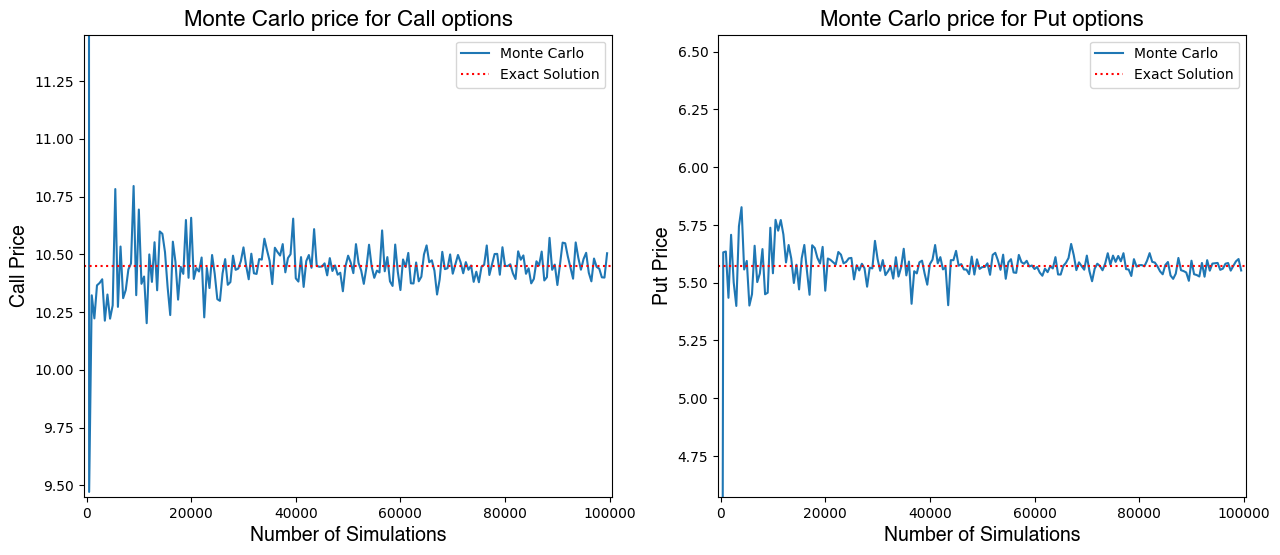

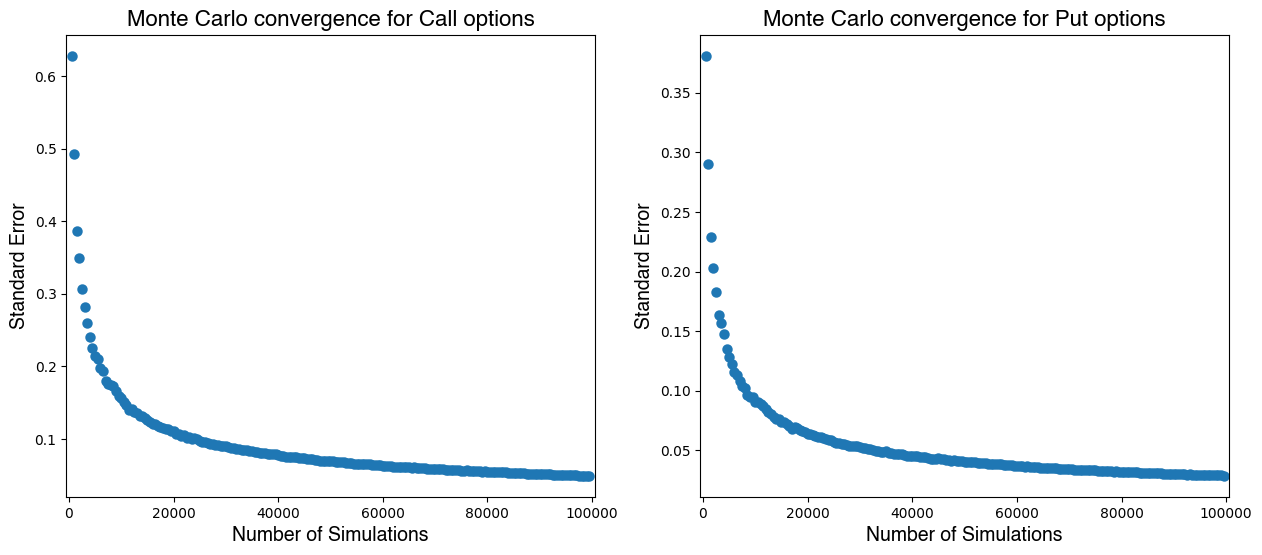

In [13]:
convergenceMC(100, 100, 1, 0.05, 0.2, 1000, 100000)
